# Generate cell distributions from Polygons and Segments  

The polygons must be already computed from cross-sectional images

**Avoid computing the boundaries again**  
For the next 3 scenarios, it is necessary to click on "cell>Run All above" after browsing to the target cell and clicking on it, this will load the needed dependencies.  
- 1D displacement test
- 2D source point test
- Generate EVs in a pre processed cross section  

[load the dependencies](#Dependencies)

**Otherwise:** [Load the dependencies](#Dependencies) first, then proceed to [process a new cross section](#Full-pipeline) 

In [1]:
%matplotlib inline
import numpy as np
import math

import os
import itertools

import pickle
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#from struct import pack
from shapely.geometry import MultiPolygon
import time

from ev_model import elements, environment
from ev_model.utilities import geometry as evmetry

sections = {
    'utj': './resources/img_polygons/3-1to3-5_L2-3_bl-utj.pickle',
    'isthmus': './resources/img_polygons/3-1to3-5_L2-3_tl-isth_fixed.pickle',
    'ia-junction': './resources/img_polygons/3-1to3-5_L2-3_c.pickle',
    'ampulla': './img_polygons/3-1to3-5_L2-3_tr-amp_2.pickle',
    'infundibulum': './img_polygons/3-1to3-5_L2-3_br-inf.pickle'
}

print(f"For a temperature of {elements.tempC}C ({elements.const_Temperature_K} Kelvin) water has a viscosity of {elements.const_water_viscosity}")
print(f"const_Boltzmann * const_Temperature_K = {elements.const_Boltzmann * elements.const_Temperature_K}")
print(f"6. * math.pi * const_water_viscosity = {6. * math.pi * elements.const_water_viscosity}")

For a temperature of 20C (293.15 Kelvin) water has a viscosity of 0.0010016
const_Boltzmann * const_Temperature_K = 4.0473766476e-21
6. * math.pi * const_water_viscosity = 0.018879715211013223


# Dependencies
After clicking on this cell, select `Cell>Run All above` (or `Run>Run All Above Selected Cell` on Jupyter Lab), this will load the needed dependencies. Then proceed to the desired scenario or [Process a new cross section](#Full-pipeline)  

Available scenarios:  
- [Simple tests](#Simple-tests-(alternative-pipeline))
  - [1D displacement test](#1D-displacement-test)
  - [2D source point test](#2D-source-point-test)
  - [2D collisions test](#2d-collisions-test)
- [Load previously computed cell-distributions from file](#Load-previously-computed-cell-distributions-from-file)
- Generate EVs from a pre-processed cross-section by executing the [Full-pipeline](#Full-pipeline)  
- [Full experiments](#Full-experiments)

## Simple tests (alternative pipeline)  
For the following two tests, we defined a simple pipeline as follows  

1. Produce a simple geometry  
  1. 1D source point test  
  1. 2D source point test (EVs inside a circumference)  
1. Generate the cell distributions  
1. Export the 0.xml file  

The base unit for the experiments is the micrometer ($\mu m$)  
## 1D displacement test

In [ ]:
base_filename = '1D_test'
dt = 0.05
degrees_of_freedom = 1
n = 100
version = 28
threshold_secretory = 0.2

segments = []
avg_cell_diameter = 4.5 # um

# this would produce a playground area of 900 units (pixels) which translates to 900 um, almost a millimeter
coords = np.array([(0, -450),(0, 450), (0, 450), (0,-450), (0, -450)])
segments.extend(environment.process_edge([], coords[0], coords[1], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[2], coords[3], avg_cell_diameter, 0))
cells, secretory, ciliary = environment.produce_cells(segments, probabilistic=False, threshold_secretory = threshold_secretory)
print(f'total cells: {len(cells)}, secretory: {len(secretory)}, ciliary: {len(ciliary)}')

source_points, max_spts_per_cell = environment.generate_source_points_from_cells(secretory, debug_log=False)
print(f"source points: {len(source_points['location'])}")
# produce the EVs

new_evs = environment.generate_evs_from_source_points(n, source_points, debug_log=False)

In [ ]:
environment.visualize_distributions(cells, secretory, ciliary, threshold_secretory = threshold_secretory, normals=False, scalebar=False, save=False, zoom_in=False, autoscale=True)

In [ ]:
save_0xml_file(evs, n, dt, degrees_of_freedom, base_filename, target_spts_per_cell=0, 
               version=version, boundaries=False, ev_ev_collisions=False, cells=None, new_evs=False,
               new_evs_interval_seconds=5, new_evs_threshold=0.95, seconds_in_initial_state=0.)

## 2D source point test (broken)

In [ ]:
base_filename = '2D_sp'
dt = 0.025
degrees_of_freedom = 2

segments = []
avg_cell_diameter = 4.5 # um
coords = np.array([(0, -4),(0, 4), (0, 4), (0,-4), (0, -4)])
segments.extend(environment.process_edge([], coords[0], coords[1], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[2], coords[3], avg_cell_diameter, 0))
cells, secretory, ciliary = environment.produce_cells(segments, probabilistic=False)

n = 2**12
version = 28
circle_radius = 45 #um
evs = environment.generate_evs_in_circle(n, circle_radius)

In [ ]:
environment.visualize_distributions(cells, secretory, ciliary, threshold_secretory = threshold_secretory, normals=False, scalebar=False, save=False, zoom_in=False, autoscale=True)

In [ ]:
save_0xml_file(evs, n, dt, degrees_of_freedom, base_filename, target_spts_per_cell=0, 
               version=version, boundaries=False, ev_ev_collisions=False, cells=None, new_evs=False,
               new_evs_interval_seconds=5, new_evs_threshold=0.95, seconds_in_initial_state=0.)

## 2D source points proximity test

We place EVs inside a 3um by 3um box to check for collisions against walls and EVs.


In [ ]:
base_filename = '2D_proximity_test'
dt=0.005
degrees_of_freedom=2
# produce N EVs
n = 32
version = 28
target_spts_per_cell = 11

#set_dt_and_dof(dt, degrees_of_freedom)

segments = []
avg_cell_diameter = 4.5 # um
coords = np.array([(1, 1.5), (4.6, 1), (5, 2), (4.3, 4),
                   (4.3, 8), (3.7, 8), (3.7,4), (4, 2)])
segments.extend(environment.process_edge([], coords[0], coords[1], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[1], coords[2], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[2], coords[3], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[3], coords[4], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[4], coords[5], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[5], coords[6], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[6], coords[7], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[7], coords[0], avg_cell_diameter, 0))

# check distance between segments


cells, secretory, ciliary = environment.produce_cells(segments, probabilistic=True, threshold_secretory = 0.5)
print(f'total cells: {len(cells)}, secretory: {len(secretory)}, ciliary: {len(ciliary)}')

source_points, max_spts_per_cell = environment.generate_source_points_from_cells(secretory, debug_log=False)
print(f"source points: {len(source_points['location'])}")


new_evs = environment.generate_evs_from_source_points(n, source_points, debug_log=False)

In [ ]:
environment.visualize_distributions(cells, secretory, ciliary, threshold_secretory = 0.75, normals=True, scalebar=False, evs=new_evs, save=False)

In [ ]:
save_0xml_file(new_evs, n, dt, degrees_of_freedom, base_filename, target_spts_per_cell, 
               version, boundaries=True, ev_ev_collisions=True, cells=cells, new_evs=True,
               new_evs_interval_seconds=5, new_evs_threshold=0.95, seconds_in_initial_state=2.0)

## 2D Full collisions and EV production test

We place EVs inside a n by n um box to check for collisions against walls and EVs.

In [ ]:
base_filename = '2D_collisions_w_newEvs'

segments = []
avg_cell_diameter = 4.5 # um
coords = np.array([(1, 13), (1, 1), (13, 1), (13, 13),
                   (4, 7), (7, 4), (10, 7), (7, 10) ])
segments.extend(environment.process_edge([], coords[0], coords[1], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[1], coords[2], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[2], coords[3], avg_cell_diameter, 0))
segments.extend(environment.process_edge([], coords[3], coords[0], avg_cell_diameter, 0))
# inner
segments.extend(environment.process_edge([], coords[4], coords[5], avg_cell_diameter, 1, inside_another=True))
segments.extend(environment.process_edge([], coords[5], coords[6], avg_cell_diameter, 1, inside_another=True))
segments.extend(environment.process_edge([], coords[6], coords[7], avg_cell_diameter, 1, inside_another=True))
segments.extend(environment.process_edge([], coords[7], coords[4], avg_cell_diameter, 1, inside_another=True))

cells, secretory, ciliary = environment.produce_cells(segments, probabilistic=True, threshold_secretory = 0.5)
print(f'total cells: {len(cells)}, secretory: {len(secretory)}, ciliary: {len(ciliary)}')

source_points, max_spts_per_cell = environment.generate_source_points_from_cells(secretory, debug_log=False)
print(f"source points: {len(source_points['location'])}")

dt=0.005
degrees_of_freedom=2
# produce N EVs
n = 64 #int(len(secretory)) * 2
version = 28
target_spts_per_cell = 11

new_evs = environment.generate_evs_from_source_points(n, source_points, debug_log=False)

In [ ]:
environment.visualize_distributions(cells, secretory, ciliary, threshold_secretory = 0.5, normals=True, scalebar=False, evs=new_evs, save=False)

In [ ]:
save_0xml_file(new_evs, n, dt, degrees_of_freedom, base_filename, target_spts_per_cell, 
               version, boundaries=True, ev_ev_collisions=True, cells=cells, new_evs=True,
               new_evs_interval_seconds=5, new_evs_threshold=0.95, seconds_in_initial_state=1.9)

# A model of Extracellular Vesicles behaviour
The state of the art about extracellular vesicle offers significant detail about the biological characterisations of their content, we identified some gaps regarding other systemic characteristics such as production rate, diffusion coefficient, mass, lifespan, and decay or decomposition rate. This complicated things a bit for creating our first model of EV behaviour. However, we expect that our findings will eventually help reduce this gap.

In [ ]:
# In the images 100 um are represented by 48 pixels
scale = 100/48
width_in_pixels = 2717
height_in_pixels = 1410
width = width_in_pixels * scale
height = height_in_pixels * scale
depth = 4

vol_um = width*height*depth

print(f'w: {width} um, h: {height} um, d: {depth} um, vol: {vol_um:,.2f} um^3 -> ')

## The environment (Oviduct measurements)

After measuring the dimensions of the oviduct from histological images, we have identified the following:  

| Region| Width ($\mu m$) | Height ($\mu m$) |  
|:-:|-:|-:|  
|UTJ|0|0 |  
|Isthmus|1,000|1,000|  
|IA junction|0|0|
|Ampulla|5,560|2,937|
|Infundibulum|0|0|
  
Sources:  
- Ampulla (D:\gDrive\Histology\PigHistologyImages\3-1to3-5\L2-3\tr-amp\Untitled-1-modified-b.w.jpg) w: 2717 px, h: 1410 px  
- Isthmus (D:\gDrive\Histology\PigHistologyImages\3-1to3-5\L2-3\??\??.jpg)  

Next, we load the data from the environment from a set of previously prepared files.

### Load previously computed cell distributions from file

Previously computed distributions are stored in the directory 'distributions'. The files there are related to the experiment they belong by the first part of their name. As an example, the for the experiment 'ampulla_(3-1to3-5_L2-3_tr-amp)\_2' would produce the files:  

$$
V2 files
\begin{cases}
\text{3-1to3-5_L2-3_tr-amp_2__distribution_80-20_s-c__allCells.pickle} & \text{w/ all cells}\\
\text{3-1to3-5_L2-3_tr-amp_2__distribution_80-20_s-c__ciliary.pickle} & \text{ciliary cells}\\
\text{3-1to3-5_L2-3_tr-amp_2__distribution_80-20_s-c__secretory.pickle} & \text{secretory cells}
\end{cases}
$$
*Note: the number 80, 20 corresponds to an 80/20 percent distribution of secretory/ciliary cells*

$$
\text{v1 files}
\begin{cases}
\text{`ampulla_(3-1to3-5_L2-3_tr-amp)_2_0_boundaries.evbin`} & \text{the boundaries} \\
\text{`ampulla_(3-1to3-5_L2-3_tr-amp)_2_0_starting_points.evbin`} & \text{the starting points}  
\end{cases}
$$


# The ampulla

The first cell distributions were generated from the cross-sections of the ampulla. This process follows

In [ ]:
# preset environments:
presets = [{'amp':'3-1to3-5_L2-3_tr-amp_2', 's':'80', 'c':'20'}]
p = 0
base_filename = presets[p]['amp']

cells, secretory, ciliary = load_cell_distributions(base_filename, presets[p]['s'], presets[p]['c'])
#distributions = load_distributions(base_filename, presets[p]['s'], presets[p]['c'])
#f"loaded {len(distributions['cells']):,d} cells from which the distribution is as follows: ciliary {len(distributions['ciliary']):,d}, secretory: {len(distributions['secretory']):,d}"
f"loaded {len(cells):,d} cells from which the distribution is as follows: secretory: {len(secretory):,d}, ciliary {len(ciliary):,d}"

## The Vesicles
Each vesicle is represented as a particle, assigning parameters such as mass, position, and velocity. Then, the interactions between the vesicles or with the oviduct were decided to be treated as perfectly plastic collisions observing the principles of conservation of momentum, angle, and energy.

### Size
As previously discussed in our literature review, it is well accepted that in general the range of EV sizes lies within 10 nm and 1500 nm. And depending on their biogenesis, this range becomes narrower. In the case of oviductosomes, experimental data has shown they typically have diametral size between 30 and 300 nm. However, more specific characterisation has narrowed down this range even further to be between 80 and 150 nm. Therefore, for the first version of our model, we decided to work with sizes in this range only (80 to 150 nm or 0.080 to 0.150 um) using increments of 10 nm (0.010um).

### Mass
From the published data of the molecular mass for an exosome with a diameter of 100nm, produced by blood plasma cells, we derived a mass of 1.34e-24 Kg per vesicle. Then, the corresponding mass for the range of sizes described was obtained by simple extrapolation. This procedure gave us the following masses.  

| EV diameter (nm) | Mass (Kg) |  
|------------------|-----------|
|30|1.64397E-20|
|40|2.19196E-20|
|50|2.73995E-20|
|60|3.28794E-20|
|70|3.83593E-20|
|80|4.38393E-20|
|90|4.93192E-20|
|100|5.47991E-20|
|110|6.0279E-20|
|120|6.57589E-20|
|130|7.12388E-20|
|140|7.67187E-20|
|150|8.21986E-20|

### Displacement
Given that the vesicles are governed by physical laws, we estimate the corresponding diffusion rate for each vesicle based on their diameter. For this we use the Stokes-Einstein equation where $k_B$ is the Boltzman constant, $T$ is the absolute temperature. And the frictional coefficient, acting against the spherical particle is given by the divisor. Where $\eta$ is the dynamic viscosity of water at $T$ temperature, and $r$ is the radius of the vesicle.

$$
D = \frac{k_B T}{6 \pi \eta r}
$$
The Stokes-Einstein equation  

We use the computed value for the displacement to estimate the initial velocity of the particle.

In [ ]:
# produce the EVs
n = 25000
#new_evs = generate_evs_from_source_points(n, distributions['secretory'])
new_evs = generate_evs_from_source_points(n, secretory)

# save the cell distributions to file for future reuse
export_cell_distributions(base_filename, threshold_secretory, cells, secretory, ciliary)

# export the initial states file
dt = 0.001194158
degrees_of_freedom = 2

# save_0xml_file(new_evs, n, degrees_of_freedom, base_filename, version=18, boundaries = True, ev_ev_collisions = False, cells=cells)
save_0xml_file(new_evs, n, dt, degrees_of_freedom, base_filename, target_spts_per_cell, 
               version, boundaries=True, ev_ev_collisions=False, cells=cells)

------
# Full pipeline

1. Image processing (edge detection, edge to polygon conversion, polygon persistency) must be done in a separate notebook named: `00_Xsec-contours`. The list of Shapely Polygons produced should be loaded here.   
1. [Loading the pre-computed polygons](#Polygon-loading)  
1. [Generate the hypothetical cell distributions](#Generate-the-hypothetical-cell-distributions)  
1. [Export the computed cell distributions](#Export-the-computed-cell-distributions)
1. Generate the 0.xml file  


## Polygon loading

The following pickled files with polygons are available:  
`.\img\polygons_3-1to3-5_L2-3_bl-utj.pickle`,  
`.\img\polygons_3-1to3-5_L2-3_tl-isth.pickle`,  
`.\img\polygons_3-1to3-5_L2-3_c.pickle`,  
`.\img\polygons_3-1to3-5_L2-3_tr-amp_2.pickle`,  
`.\img\polygons_3-1to3-5_L2-3_br-inf.pickle`  

Base filename: _polygons/3-1to3-5_L2-3_tl-isth_fixed


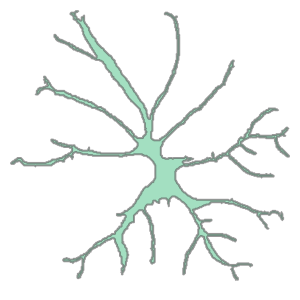

In [4]:
working_section = 'isthmus'
base_filename = sections[working_section][len('.\img\polygons_'):- len('.pickle')]
print(f'Base filename: {base_filename}')
with open(sections[working_section], 'rb') as pickled_source:
    polygons = pickle.load(pickled_source)
MultiPolygon(polygons)

After the previous step, the cell distributions can be computed

## Generate the hypothetical cell distributions

Firstly, we must identify the segments in each edge of the polygons. Then, the cells are generated from them.  

In [20]:
avg_cell_diameter = 4.5
threshold_secretory = 0.00000001

segments = environment.identify_segments_in_polygons(polygons, avg_cell_diameter)
print(f'Computed {len(segments)} segments in all polygons')

cells, secretory, ciliary, _ = environment.produce_cells(segments, True, threshold_secretory)
print(f'Generated {len(cells)} cells. The distribution is: {len(secretory)} secretory, {len(ciliary)} ciliary')

source_points = environment.generate_source_points_from_cells(secretory, debug_log=False)
print(f"source points: {len(source_points[0]['location'])}, max source points per cell: {source_points[1]}")

Computed 4428 segments in all polygons
Generated 4428 cells. The distribution is: 3295 secretory, 1133 ciliary
MAX NUMBER OF SOURCE POINTS PER CELL is 11, 34 cells have such many cells
No cells with 0 source points
source points: 15396, max source points per cell: 11


------
# Full experiments

[back to start](#Dependencies)

# UTJ
Expected run time: from 69 sec to 2.26 sec, finally 2.87 sec with filtering

In [3]:
# produce the EVs
environment.setup_experiment(sections=sections, version=31, working_section='utj', new_evs_interval_seconds=15, 
                             new_evs_threshold=0.95, threshold_secretory=0.3, n = 10)

Base filename: 3-1to3-5_L2-3_bl-utj
Computed 6871 segments in all polygons. Elapsed 0.29
Generated 6871 cells. The distribution is: 3741 secretory and 3130 ciliary. Elapsed 0.62
Removed 60  potentially conflictive source points.As a result, 16 secretory cells have no source points. These will become ciliary cells.
Updated lists: 6871 cells, 3725 secretory, 3146 ciliary
Filtered source points. Elapsed 0.81
Exported file: ./distributions/3-1to3-5_L2-3_bl-utj_30-70_s-c_secretory.pickle
Exported file: ./distributions/3-1to3-5_L2-3_bl-utj_30-70_s-c_ciliary.pickle
Exported file: ./distributions/3-1to3-5_L2-3_bl-utj_30-70_s-c_allCells.pickle
EVs generated. Elapsed 0.00299072265625
file saved as: D:\iterations\v31\3-1to3-5_L2-3_bl-utj_0.0k_intCol_newEvs\0_0.0k_intCol_newEVs.xml
Total time: 3.00 seconds


------

# Isthmus

Expected run time: 33 sec, now ~ 2.17 sec

In [2]:
# load the section's polygons
environment.setup_experiment(version=33, working_section='isthmus', new_evs_interval_seconds=2, 
                             new_evs_threshold=0.9, threshold_secretory=0.001, n= 0)

Base filename: 3-1to3-5_L2-3_tl-isth_fixed
Computed 4428 segments in all polygons. Elapsed 0.16
OLD METHOD: Generated 4428 cells. The distribution is: 3292 secretory and {len(ciliary)} ciliary. Elapsed {time.time()-s:.2f}


AttributeError: 'list' object has no attribute 'location'

------

# IA junction
Expected run time: from 1002 sec (~16min) to 7.6 sec

In [6]:
# produce the EVs
environment.setup_experiment(sections=sections, version=31, working_section='ia-junction', new_evs_interval_seconds=15, new_evs_threshold=0.95, threshold_secretory=0.5)

Base filename: 3-1to3-5_L2-3_c
Computed 30922 segments in all polygons. Elapsed 1.10
Generated 30922 cells. The distribution is: 12328 secretory and 18594 ciliary. Elapsed 2.25
Removed 90  potentially conflictive source points.As a result, 27 secretory cells have no source points. These will become ciliary cells.
Updated lists: 30922 cells, 12301 secretory, 18621 ciliary
Filtered source points. Elapsed 1.17
Exported file: ./distributions/3-1to3-5_L2-3_c_50-50_s-c_secretory.pickle
Exported file: ./distributions/3-1to3-5_L2-3_c_50-50_s-c_ciliary.pickle
Exported file: ./distributions/3-1to3-5_L2-3_c_50-50_s-c_allCells.pickle
EVs generated. Elapsed 0.008975982666015625
file saved as: D:\iterations\v31\3-1to3-5_L2-3_c_0.0k_intCol_newEvs\0_0.0k_intCol_newEVs.xml
Total time: 10.36 seconds


------

# Ampulla
Expected runtime: 5068 sec ~ 84 min, now 15 sec

In [7]:
# produce the EVs
environment.setup_experiment(sections=sections, version=31, working_section='ampulla', new_evs_interval_seconds=15, new_evs_threshold=0.95, threshold_secretory=0.5)

Base filename: 3-1to3-5_L2-3_tr-amp_2
Computed 58979 segments in all polygons. Elapsed 2.06
Generated 58979 cells. The distribution is: 28974 secretory and 30005 ciliary. Elapsed 4.76
Removed 20  potentially conflictive source points.As a result, 0 secretory cells have no source points. These will become ciliary cells.
Updated lists: 58979 cells, 28974 secretory, 30005 ciliary
Filtered source points. Elapsed 1.64
Exported file: ./distributions/3-1to3-5_L2-3_tr-amp_2_50-50_s-c_secretory.pickle
Exported file: ./distributions/3-1to3-5_L2-3_tr-amp_2_50-50_s-c_ciliary.pickle
Exported file: ./distributions/3-1to3-5_L2-3_tr-amp_2_50-50_s-c_allCells.pickle
EVs generated. Elapsed 0.022939443588256836
file saved as: D:\iterations\v31\3-1to3-5_L2-3_tr-amp_2_0.0k_intCol_newEvs\0_0.0k_intCol_newEVs.xml
Total time: 20.51 seconds


------

# Infundibulum
Expected runtime: 1969 sec ~ 32 min, now 10 sec

In [8]:
environment.setup_experiment(sections=sections, version=31, working_section='infundibulum', new_evs_interval_seconds=15, new_evs_threshold=0.95, threshold_secretory=0.5)

Base filename: 3-1to3-5_L2-3_br-inf
Computed 43577 segments in all polygons. Elapsed 1.53
Generated 43577 cells. The distribution is: 17414 secretory and 26163 ciliary. Elapsed 3.14
Removed 126  potentially conflictive source points.As a result, 50 secretory cells have no source points. These will become ciliary cells.
Updated lists: 43577 cells, 17364 secretory, 26213 ciliary
Filtered source points. Elapsed 1.47
Exported file: ./distributions/3-1to3-5_L2-3_br-inf_50-50_s-c_secretory.pickle
Exported file: ./distributions/3-1to3-5_L2-3_br-inf_50-50_s-c_ciliary.pickle
Exported file: ./distributions/3-1to3-5_L2-3_br-inf_50-50_s-c_allCells.pickle
EVs generated. Elapsed 0.011968135833740234
file saved as: D:\iterations\v31\3-1to3-5_L2-3_br-inf_0.0k_intCol_newEvs\0_0.0k_intCol_newEVs.xml
Total time: 14.43 seconds
